In [1]:
using HDF5, JLD

# JLD: Serializing Julia objects in HDF5 format

### Simon Kornblith

# The JLD format

# The ideal data storage format

 - Expressive
 - Embeds data structure descriptions
 - Fast
 - Compact on disk
 - Standardized

# CSV

 - ❌ Expressive object model
 - ➖ Embeds data structure descriptions
 - ➖ Fast (depends on reader)
 - ❌ Compact on disk
 - ✅ Standardized

# `Base.serialize`

 - ✅ Expressive object model
 - ❌ Embeds data structure descriptions
 - ✅ Fast (usually)
 - ✅ Compact on disk
 - ❌ Standardized

# JLD

 - ✅ Expressive object model
 - ✅ Embeds data structure descriptions
 - ➖ Fast (depends on data types)
 - ✅ Compact on disk
 - ✅ Standardized

# HDF5

 - A "standard" format for scientific data (dates back to 1987)
 - Lots of features
 - Only one implementation (`libhdf5`)

# HDF5 data model

<img src="https://www.hdfgroup.org/HDF5/doc/FF-IH_FileGroup.gif" style="margin:auto; width:25%; height:auto;">
<div style="font-size: 0.5em">(From https://www.hdfgroup.org/HDF5/doc/H5.intro.html)</div>

# HDF5 datasets

<img src="https://www.hdfgroup.org/HDF5/doc/UG/Images/Dsets_fig1.JPG" style="margin:auto; width:85%; height:auto">
<div style="font-size: 0.5em">(From https://www.hdfgroup.org/HDF5/doc/UG/UG_frame10Datasets.html)</div>

# HDF5 datatypes

<img src="https://www.hdfgroup.org/HDF5/doc/UG/Images/Dmodel_fig9.JPG" style="margin:auto;">

# How JLD maps Julia to HDF5

 - Int\*, Float\* → Atomic (built-in) types
 - ByteStrings → Strings
 - Composite data types and tuples → Compound types
 - `bitstype`s → Opaque types
 - Pointers → References

# Atomic datatypes

In [11]:
x = 1
@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   DATASET "x" {
      DATATYPE  H5T_STD_I64LE
      DATASPACE  SCALAR
      DATA {
      (0): 1
      }
   }
}
}



# Atomic datatypes

In [20]:
x = 1.1
@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   DATASET "x" {
      DATATYPE  H5T_IEEE_F64LE
      DATASPACE  SCALAR
      DATA {
      (0): 1.1
      }
   }
}
}



# Strings (fixed-length)

In [21]:
x = "abc"
@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   DATASET "x" {
      DATATYPE  H5T_STRING {
         STRSIZE 3;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "abc"
      }
   }
}
}



# Strings (variable-length)

In [22]:
x = ["the", "quick", "brown", "fox"]
@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   DATASET "x" {
      DATATYPE  H5T_STRING {
         STRSIZE H5T_VARIABLE;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
      DATA {
      (0): "the", "quick", "brown", "fox"
      }
   }
}
}



# Compound datatypes

In [3]:
immutable MyType
    an_int::Int
    a_float::Float64
end
x = MyType(1, 1.1)

@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   GROUP "_types" {
      DATATYPE "00000001" H5T_COMPOUND {
         H5T_STD_I64LE "an_int_";
         H5T_IEEE_F64LE "a_float_";
      }
         ATTRIBUTE "julia type" {
            DATATYPE  H5T_STRING {
               STRSIZE 6;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_ASCII;
               CTYPE H5T_C_S1;
            }
            DATASPACE  SCALAR
            DATA {
            (0): "MyType"
            }
         }
   }
   DATASET "x" {
      DATATYPE  "/_types/00000001"
      DATASPACE  SCALAR
      DATA {
      (0): {
            1,
            1.1
         }
      }
   }
}
}



# Compound datatypes

In [4]:
immutable MyNestedType
    mytype1::MyType
    mytype2::MyType
end
x = MyNestedType(MyType(0, 1), MyType(2, 3))

@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   GROUP "_types" {
      DATATYPE "00000001" H5T_COMPOUND {
         H5T_STD_I64LE "an_int_";
         H5T_IEEE_F64LE "a_float_";
      }
         ATTRIBUTE "julia type" {
            DATATYPE  H5T_STRING {
               STRSIZE 6;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_ASCII;
               CTYPE H5T_C_S1;
            }
            DATASPACE  SCALAR
            DATA {
            (0): "MyType"
            }
         }
      DATATYPE "00000002" H5T_COMPOUND {
         H5T_COMPOUND {
            H5T_STD_I64LE "an_int_";
            H5T_IEEE_F64LE "a_float_";
         } "mytype1_1";
         H5T_COMPOUND {
            H5T_STD_I64LE "an_int_";
            H5T_IEEE_F64LE "a_float_";
         } "mytype2_1";
      }
         ATTRIBUTE "julia type" {
            DATATYPE  H5T_STRING {
               STRSIZE 12;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_ASCII;
               CTYPE H5T_C_S1;
            

# Compound datatypes: parametrized types

In [32]:
xdump(Complex)

Complex{T<:Real}::DataType  <: Number
  re::T<:Real
  im::T<:Real


In [30]:
x = 1.0 + 2.0im
@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   GROUP "_types" {
      DATATYPE "00000001" H5T_COMPOUND {
         H5T_IEEE_F64LE "re_";
         H5T_IEEE_F64LE "im_";
      }
         ATTRIBUTE "julia type" {
            DATATYPE  H5T_STRING {
               STRSIZE 26;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_ASCII;
               CTYPE H5T_C_S1;
            }
            DATASPACE  SCALAR
            DATA {
            (0): "Base.Complex{Core.Float64}"
            }
         }
   }
   DATASET "x" {
      DATATYPE  "/_types/00000001"
      DATASPACE  SCALAR
      DATA {
      (0): {
            1,
            2
         }
      }
   }
}
}



# HDF5 references

- Julia represents fields and array elements as pointers when the defined type is not `isbits`:
  - "Non-leaf" types
    - Abstract types (`Integer`, `Any`)
    - Union types (`Union(Int, Float64)`)
    - Types that are not fully parametrized (`Array{Int}`)
  - Mutable (`type`, `Array`)
  - Immutables that contain non-`isbits` fields
- Anytime an object is stored by reference in Julia, we store it by reference in HDF5

# HDF5 reference arrays

In [12]:
x = [1, 2, 3]
y = Vector{Int}[x, x]

@save "example.jld" y
@load "example.jld" y

push!(y[1], 4)
y[2]

4-element Array{Int64,1}:
 1
 2
 3
 4

# HDF5 reference fields

In [13]:
immutable MyNonBitsType
    isbits_field::Int
    any_field
end

x = MyNonBitsType(1, "second field")
@save "example.jld" x
println(readall(`h5dump example.jld`));

HDF5 "example.jld" {
GROUP "/" {
   GROUP "_refs" {
      DATASET "00000001" {
         DATATYPE  H5T_STRING {
            STRSIZE 12;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_ASCII;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "second field"
         }
      }
   }
   GROUP "_types" {
      DATATYPE "00000001" H5T_COMPOUND {
         H5T_STD_I64LE "isbits_field_";
         H5T_REFERENCE { H5T_STD_REF_OBJECT } "any_field_";
      }
         ATTRIBUTE "julia type" {
            DATATYPE  H5T_STRING {
               STRSIZE 13;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_ASCII;
               CTYPE H5T_C_S1;
            }
            DATASPACE  SCALAR
            DATA {
            (0): "MyNonBitsType"
            }
         }
   }
   DATASET "x" {
      DATATYPE  "/_types/00000001"
      DATASPACE  SCALAR
      DATA {
      (0): {
            1,
            DATASET 3216 /_refs/00000001 
   

# Other types

 - UTF16Strings (variable-length arrays)
 - Symbols (variable-length strings)
 - BigInts and BigFloats (variable-length strings)
 - Associatives (store by keys and values)

TODO: Allow specification of custom serialization formats ([#191](https://github.com/timholy/HDF5.jl/pull/191))

# The JLD implementation

# Implementation (writing)

 - Map Julia type to HDF5 type
 - Dynamically generate code to translate Julia object to HDF5 data (cached)
 - Run dynamically generated function
 - Create HDF5 dataspace corresponding to object
 - Create dataset and write data to HDF5 file

# Implementation (type translation)

Defined in [jld_types.jl](https://github.com/timholy/HDF5.jl/blob/master/src/jld_types.jl):

 - <span style="font-size:0.8em">`h5type(::JldFile, ::DataType, commit::Bool)`</span><br>
   Gets the HDF5 datatype for an object itself
 - <span style="font-size:0.8em">`h5fieldtype(::JldFile, ::DataType, commit::Bool)`</span><br>
   Gets the HDF5 datatype for an object field or for array elements of that type
   - Differs from `h5type` for objects that have reference semantics
 - <span style="font-size:0.8em">`h5convert(out::Ptr, ::JldFile, obj, ::JldWriteSession)`</span><br>
   Converts an object to HDF5 data layout

# Implementation (reading)

 - Map HDF5 type to Julia type
   - If HDF5 type corresponds to a Julia type in the workspace, use it
   - Otherwise, reconstruct type based on HDF5 type
 - Map HDF5 dataspace to Julia dataspace
 - Dynamically generate code to translate HDF5 data to Julia object
 - Read data and convert to Julia

# Type reconstruction demo

In [17]:
module Dummy
using HDF5, JLD
immutable MyType
    an_int::Int
    a_float::Float64
end
x = MyType(1, 1.1)
@save "example.jld" x
end

module Dummy
using HDF5, JLD
@load "example.jld" x
end

xdump(Dummy.x)

JLD.##Dummy.MyType#16996 
  an_int: Int64 1
  a_float: Float64 1.1


# Type reconstruction demo

In [23]:
xdump(typeof(Dummy.x))

JLD.##Dummy.MyType#14539::DataType  <: Any
  a::Int64::DataType  <: Signed
  b::Float64::DataType  <: FloatingPoint


In [7]:
module Dummy
using HDF5, JLD
immutable MyType
    an_integer::Integer
    a_real::Real
end
x = MyType(1, 1.1)
@save "example.jld" x
end

module Dummy
using HDF5, JLD
@load "example.jld" x
end

xdump(Dummy.x)

JLD.##Dummy.MyType#16820 
  an_integer: Int64 1
  a_real: Float64 1.1


In [8]:
xdump(typeof(Dummy.x))

JLD.##Dummy.MyType#16820::DataType  <: Any
  an_integer::Any::DataType  <: Any
  a_real::Any::DataType  <: Any


# JLD performance

- Optimal for arrays of simple types
- Pretty good for immutables and strings
- Very bad for objects with references 😧

# JLD performance (atomic)

In [3]:
using Benchmarks
function benchmark_jld_write(obj; kws...)
    f = jldopen("benchmark.jld", "w"; kws...)
    t = @elapsed write(f, "obj", obj)
    close(f)
    [begin
        f = jldopen("benchmark.jld", "w"; kws...)
        t = @elapsed write(f, "obj", obj)
        close(f)
        t
    end for i = 1:10]
end
function benchmark_serialize_write(obj)
    f = open("benchmark.jls", "w")
    t = @elapsed serialize(f, obj)
    close(f)
    [begin
        f = open("benchmark.jls", "w")
        t = @elapsed serialize(f, obj)
        close(f)
        t
    end for i = 1:10]
end
function benchmark_jld_read(obj)
    f = jldopen("benchmark.jld")
    t = @elapsed read(f, "obj")
    close(f)
    [begin
        f = jldopen("benchmark.jld")
        t = @elapsed read(f, "obj")
        close(f)
        t
    end for i = 1:10]
end
function benchmark_serialize_read(obj)
    f = open("benchmark.jls")
    t = @elapsed deserialize(f)
    close(f)
    [begin
        f = open("benchmark.jls")
        t = @elapsed deserialize(f)
        close(f)
        t
    end for i = 1:10]
end

using PyPlot
function plot_benchmark(jld, serialize)
    bar([1, 2], [mean(jld), mean(serialize)]*1e3,
        yerr=[std(jld)/sqrt(length(jld)), std(serialize)/sqrt(length(serialize))]*6*1e3,
        ecolor="k", color=[0.7, 0.7, 0.7])
    gca()[:set_xticks](1.4:2.4)
    gca()[:set_xticklabels](["JLD", "Base.serialize"])
    gca()[:set_xlim](0.8, 3)
end

function plot_benchmarks(obj; kws...)
    gcf()[:set_size_inches](8.0, 4)
    jld_write = benchmark_jld_write(obj; kws...)
    serialize_write = benchmark_serialize_write(obj)
    jld_read = benchmark_jld_read(obj)
    serialize_read = benchmark_serialize_read(obj)

    subplot(1, 2, 1)
    plot_benchmark(jld_write, serialize_write)
    title("Writing")
    ylabel("Time (ms)")
    
    subplot(1, 2, 2)
    plot_benchmark(jld_read, serialize_read)
    title("Reading")
end;

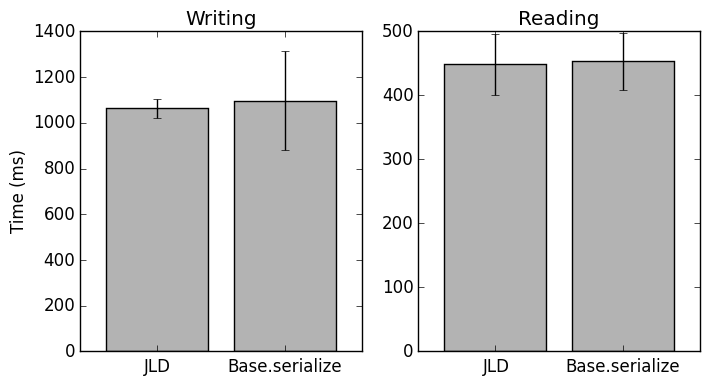

In [20]:
obj = ones(10000, 10000)
plot_benchmarks(obj);

# JLD performance (immutables)

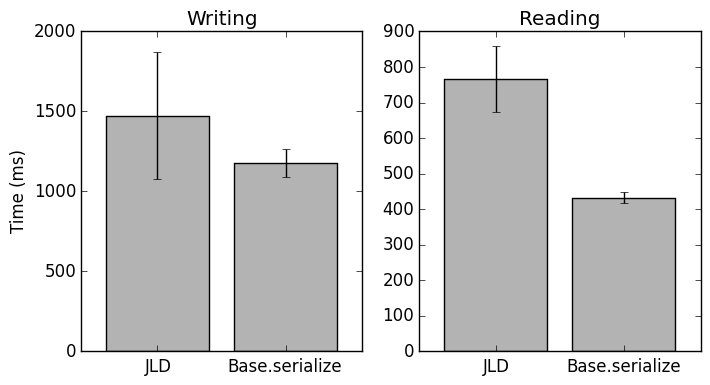

In [4]:
immutable BenchmarkImmutable
    a::Int8
    b::Int32
    c::Int64
    d::Float64
    e::Float32
end

obj = [BenchmarkImmutable(1, 2, 3, 4, 5) for i = 1:5000, j = 1:5000]
plot_benchmarks(obj);

# JLD performance (strings)

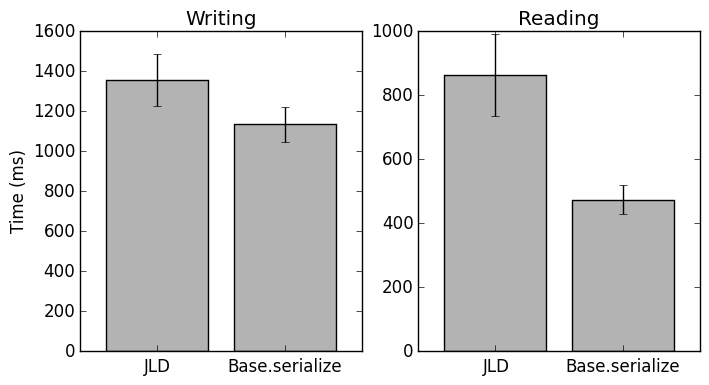

In [5]:
strings = [randstring(rand(1:100)) for i = 1:1000]
plot_benchmarks(obj);

# JLD performance (arrays of non-`isbits` types)

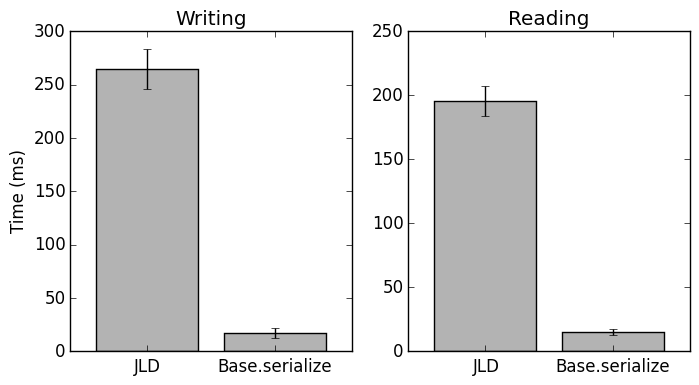

In [14]:
type BenchmarkType
    a::Int8
    b::Int32
    c::Int64
    d::Float64
    e::Float32
end

obj = [BenchmarkType(1, 2, 3, 4, 5) for i = 1:10000]
plot_benchmarks(obj);

# Why so slow?

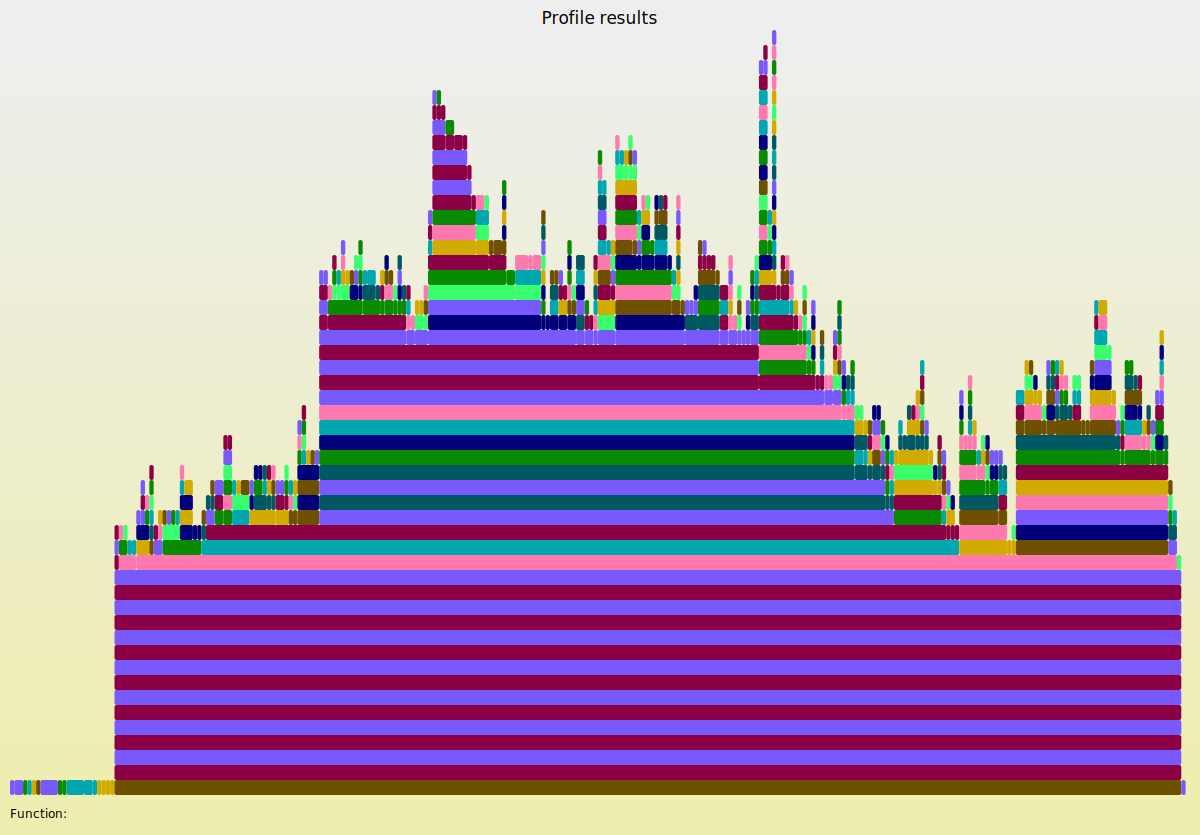

In [18]:
Profile.clear()
f = jldopen("benchmark.jld", "w")
@profile write(f, "obj", obj)
close(f)

using ProfileView
ProfileView.view(C=true)

# Some JLD tricks

# JLD options: `compress`

In [4]:
obj = ones(10000, 10000)
sizeof(obj)

800000000

In [6]:
jld = jldopen("test.jld", "w", compress=true)
write(jld, "obj", obj)
close(jld)
filesize("test.jld")

6074968

# JLD options: `mmaparrays`

In [8]:
obj = ones(10000, 10000)
@save "test.jld" obj

jld = jldopen("test.jld")
@time read(jld, "obj")
close(jld)

 440.954 milliseconds (30 allocations: 763 MB, 0.52% gc time)


In [9]:
jld = jldopen("test.jld", mmaparrays=true)
@time read(jld, "obj")
close(jld)

 221.865 microseconds (92 allocations: 3616 bytes)


# Conclusions

- JLD maps the Julia object model to HDF5
- Resulting HDF5 files are idiomatic and suitable for interchange and archival purposes
- Performance approaches `Base.serialize` for many common data types
- Performance for types with references appears to be intrinsically limited by `libhdf5`

# Acknowledgments

<img src="contributors.png" style="margin:auto; width:140%; height:auto">